# Assay Annotations
This notebook compares the sets of assays between badapple_classic and badapple2.

# Setup

In [193]:
# define DB variables
ORIGINAL_DB_NAME = "badapple_classic"
ORIGINAL_DB_HOST = "localhost"
ORIGINAL_DB_USER = "<your_usr>"
ORIGINAL_DB_PASSWORD = "<your_pw>"

COMPARISON_DB_NAME = "badapple2"
COMPARISON_DB_HOST = ORIGINAL_DB_HOST
COMPARISON_DB_USER = ORIGINAL_DB_USER
COMPARISON_DB_PASSWORD = ORIGINAL_DB_PASSWORD

In [194]:
# list of AIDs from ORIGINAL_DB
ORIGINAL_AID_PATH = "/media/jack/big_disk/data/badapple/badapple1_inputs/badapple_classic_tested.aid"
# list of AIDs from COMPARISON_DB
COMPARISON_AID_PATH = "/media/jack/big_disk/data/badapple/badapple2/badapple2_tested.aid"

In [195]:
# imports
import psycopg2
import psycopg2.extras
from psycopg2 import sql
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

## Connect to DBs

In [196]:
def db_connect(db_name: str, host: str, user: str, password: str):
    try:
        db_connection = psycopg2.connect(
            dbname=db_name,
            host=host,
            user=user,
            password=password,
            cursor_factory=psycopg2.extras.DictCursor,
        )
        db_connection.set_session(readonly=True)
        return db_connection
    except Exception as e:
        print(e)
        print(f"Error connecting to DB: {db_name}")
        return None

In [197]:
original_db_connection = db_connect(ORIGINAL_DB_NAME, ORIGINAL_DB_HOST, ORIGINAL_DB_USER, ORIGINAL_DB_PASSWORD)
comparison_db_connection = db_connect(COMPARISON_DB_NAME, COMPARISON_DB_HOST, COMPARISON_DB_USER, COMPARISON_DB_PASSWORD)

In [198]:
original_db_cur = original_db_connection.cursor()
comparison_db_cur = comparison_db_connection.cursor()

## Read AID Files

In [199]:
def read_aid_file(aid_file_path: str) -> list[int]:
    with open(aid_file_path, "r") as file:
        aid_list = [int(line.strip()) for line in file if line.strip().isdigit()]
    return aid_list

In [200]:
ORIGINAL_AID_LIST = read_aid_file(ORIGINAL_AID_PATH)
COMPARISON_AID_LIST = read_aid_file(COMPARISON_AID_PATH)

In [201]:
print(len(set(ORIGINAL_AID_LIST)), len(set(COMPARISON_AID_LIST)))
print(len(set(ORIGINAL_AID_LIST) - set(COMPARISON_AID_LIST)))
print(len(set(COMPARISON_AID_LIST) - set(ORIGINAL_AID_LIST)))

823 906
0
83


# Fetch Target Information

In [202]:
AID2TARGET_COLUMNS = "aid,target_id"
AID2TARGET_COLUMNS_LIST =  AID2TARGET_COLUMNS.split(",")

In [203]:
TARGET_COLUMNS = "target_id,type,external_id,external_id_type,name,taxonomy,taxonomy_id,protein_family"
TARGET_COLUMNS_LIST =  TARGET_COLUMNS.split(",")

In [204]:
def get_data(db_cursor, db_conn, columns: str, table: str):
    query = sql.SQL(f"SELECT {columns} FROM {table}")
    result = []
    try:
        db_cursor.execute(query)
        result = db_cursor.fetchall()
        return result
    except Exception:
        db_conn.rollback()
    return result

In [205]:
COMPARISON_TARGET_DATA = get_data(comparison_db_cur, comparison_db_connection, TARGET_COLUMNS, "target")
AID2TARGET_DATA = get_data(comparison_db_cur, comparison_db_connection, AID2TARGET_COLUMNS, "aid2target")

In [206]:
comparison_target_df = pd.DataFrame(COMPARISON_TARGET_DATA, columns=TARGET_COLUMNS_LIST)
aid2target_df = pd.DataFrame(AID2TARGET_DATA, columns=AID2TARGET_COLUMNS_LIST)
comparison_df = pd.merge(comparison_target_df, aid2target_df, on="target_id")
comparison_df

,target_id,type,external_id,external_id_type,name,taxonomy,taxonomy_id,protein_family,aid
0,1,Protein,1Y7V_A,NCBI,"Chain A, Glucosylceramidase",Homo sapiens (human),9606.0,None,360
1,2,Protein,Q02499,UniProt,Pyruvate kinase,Geobacillus stearothermophilus,1422.0,None,361
2,3,Protein,P30305,UniProt,M-phase inducer phosphatase 2,Homo sapiens (human),9606.0,Enzyme,368
3,4,Protein,Q99500,UniProt,Sphingosine 1-phosphate receptor 3,Homo sapiens (human),9606.0,GPCR,373
4,4,Protein,Q99500,UniProt,Sphingosine 1-phosphate receptor 3,Homo sapiens (human),9606.0,GPCR,485
...,...,...,...,...,...,...,...,...,...
805,594,Protein,P21964,UniProt,Catechol O-methyltransferase,Homo sapiens (human),9606.0,Enzyme,1745853
806,595,Protein,P40261,UniProt,Nicotinamide N-methyltransferase,Homo sapiens (human),9606.0,Enzyme,1745853
807,596,Protein,Q14353,UniProt,Guanidinoacetate N-methyltransferase,Homo sapiens (human),9606.0,Enzyme,1745853
808,597,Protein,P03308,UniProt,Genome polyprotein,Foot-and-mouth disease virus (strain A12),12114.0,None,1745856


In [207]:
original_df = comparison_df[comparison_df["aid"].isin(ORIGINAL_AID_LIST)]
original_target_df = original_df.drop_duplicates(subset="target_id") # some targets map to multiple assays
original_target_df.drop("aid", axis=1, inplace=True)
original_df

/tmp/ipykernel_140766/935995984.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_target_df.drop("aid", axis=1, inplace=True)


,target_id,type,external_id,external_id_type,name,taxonomy,taxonomy_id,protein_family,aid
0,1,Protein,1Y7V_A,NCBI,"Chain A, Glucosylceramidase",Homo sapiens (human),9606.0,None,360
1,2,Protein,Q02499,UniProt,Pyruvate kinase,Geobacillus stearothermophilus,1422.0,None,361
2,3,Protein,P30305,UniProt,M-phase inducer phosphatase 2,Homo sapiens (human),9606.0,Enzyme,368
3,4,Protein,Q99500,UniProt,Sphingosine 1-phosphate receptor 3,Homo sapiens (human),9606.0,GPCR,373
4,4,Protein,Q99500,UniProt,Sphingosine 1-phosphate receptor 3,Homo sapiens (human),9606.0,GPCR,485
...,...,...,...,...,...,...,...,...,...
746,540,Protein,AAC83551,NCBI,"integrase, partial",Human immunodeficiency virus 1,11676.0,None,743269
747,541,Protein,O75475,UniProt,PC4 and SFRS1-interacting protein,Homo sapiens (human),9606.0,Epigenetic,743269
748,542,Protein,P01584,UniProt,Interleukin-1 beta,Homo sapiens (human),9606.0,None,743279
749,544,Protein,P86926,UniProt,"RNA-editing ligase 1, mitochondrial",Trypanosoma brucei brucei,5702.0,None,1117264


# Process Data

In [208]:
def get_frequency_df(d: dict[str, list[str]] | pd.DataFrame, key: str, remove_str: str = None) -> pd.DataFrame:
    term_counts = Counter(d[key])
    df = pd.DataFrame(term_counts.items(), columns=['Term', 'Frequency'])
    df = df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)
    # map None to "NULL"
    df["Term"] = df["Term"].map(lambda x: "NULL" if x is None else x)
    if remove_str is not None:
        df["Term"] = df["Term"].map(lambda x: x.replace(remove_str, ''))
    return df

In [209]:
def get_high_frequency_df(df: pd.DataFrame, thresh: int, freq_col: str = "Frequency") -> pd.DataFrame:
    # group terms with frequencies <= thresh under "Other" category
    df_high_freq = df[df[freq_col] > thresh]
    other_freq_sum = df[df[freq_col] <= thresh][freq_col].sum()
    i = len(df_high_freq)
    df_high_freq.loc[i] = ['OTHER', other_freq_sum]
    df_high_freq = df_high_freq.sort_values(by=freq_col, ascending=False).reset_index(drop=True)
    return df_high_freq

# Create Plots

In [210]:
def plot_frequency_comparison(df1: pd.DataFrame, df2: pd.DataFrame, 
                              df1_label: str, df2_label: str, 
                              title_key: str, yscale: str = "linear",
                              xtick_labels: list[str] = None,
                              rotate_tick_labels: bool = True, 
                              xlabel: str = "Term",
                              ylabel: str = "Frequency",
                              title: str = None, 
                              label_bars: bool = False):
    fig, ax = plt.subplots(figsize=(10, 6))
    ind = np.arange(max(len(df1), len(df2)))
    width = 0.35
    bars1 = ax.bar(ind, df1["Frequency"], width=width, label=df1_label, color='skyblue')
    bars2 = ax.bar(ind + width, df2["Frequency"], width=width, label=df2_label, color='orange')

    # Add labels and title
    ax.set_xlabel(xlabel)
    ax.set_yscale(yscale)
    ax.set_ylabel(ylabel)
    if title is not None:
        plt.title(title)
    else:
        plt.title(f'Frequency of {title_key} Terms')
    ax.legend()
    if xtick_labels is not None:
        ax.set_xticks(ind + width / 2)
        ax.set_xticklabels(xtick_labels)
    if rotate_tick_labels:
        plt.xticks(rotation=45, ha='right')
    if label_bars:
        ax.bar_label(
            bars1, fmt="%d", label_type="edge", fontsize=10
        )
        ax.bar_label(
            bars2, fmt="%d", label_type="edge", fontsize=10
        )
    plt.tight_layout()
    plt.show()

## Target Specified
Plots showing number of assays where one (or more) targets were specified vs not

In [211]:
comparison_target_spec_aids = set(comparison_df["aid"])
original_target_spec_aids = set(original_df["aid"])

In [212]:
comparison_data = [["specified", len(comparison_target_spec_aids)], ["unspecified", len(COMPARISON_AID_LIST) - len(comparison_target_spec_aids)]]
original_data = [["specified", len(original_target_spec_aids)], ["unspecified", len(ORIGINAL_AID_LIST) - len(original_target_spec_aids)]]

In [213]:
df1 = pd.DataFrame(original_data, columns=["Term", "Frequency"])
df2 = pd.DataFrame(comparison_data, columns=["Term", "Frequency"])

In [214]:
xtick_labels = ["Specified", "Unspecified"]

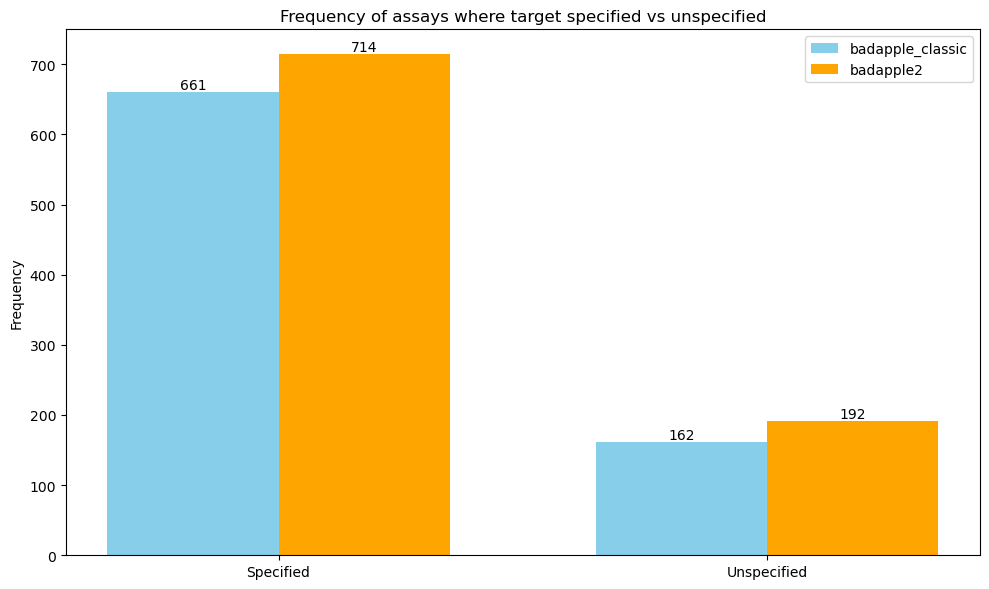

In [215]:
plot_frequency_comparison(df1, df2, ORIGINAL_DB_NAME, COMPARISON_DB_NAME, 
                          "Target Specified in Assay",
                          xtick_labels=xtick_labels,
                          rotate_tick_labels=False,
                          xlabel="",
                          title="Frequency of assays where target specified vs unspecified",
                          label_bars=True
                          )

## N Targets per Assay
(TODO)

## Target Type

In [216]:
remove_str = None
key = "type"
title_key = "Target Type"
xtick_labels = ["Protein", "Gene", "Nucleotide", "Pathway"]

In [217]:
df1 = get_frequency_df(original_target_df, key, remove_str)
df2 = get_frequency_df(comparison_target_df, key, remove_str)

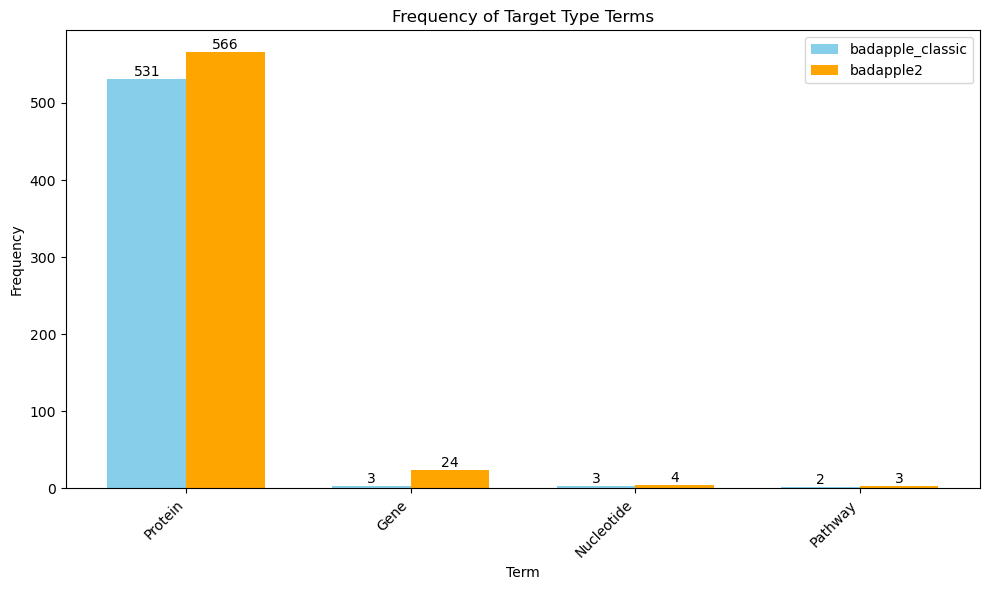

In [218]:
plot_frequency_comparison(df1, df2, ORIGINAL_DB_NAME, COMPARISON_DB_NAME, 
                          title_key, label_bars=True,
                          xtick_labels=xtick_labels)

## Protein Family
Information from Pharos. 

In [219]:
remove_str = None
key = "protein_family"
title_key = "Protein Family"
xtick_labels = ["NULL", "Enzyme", "GPCR", "Kinase", "TF", "Epigenetic", "NR", "IC", "Transporter", "TF & Epigenetic"]

In [220]:
df1 = get_frequency_df(original_target_df, key, remove_str)
df2 = get_frequency_df(comparison_target_df, key, remove_str)

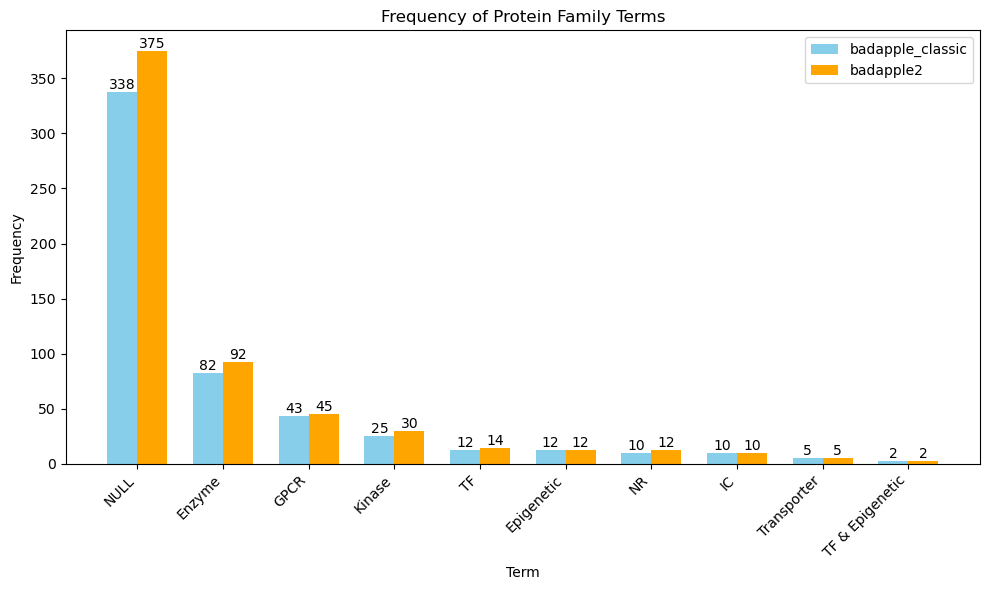

In [221]:
plot_frequency_comparison(df1, df2, ORIGINAL_DB_NAME, COMPARISON_DB_NAME, 
                          title_key, label_bars=True,
                          xtick_labels=xtick_labels)

## Taxonomy

In [222]:
remove_str = None
key = "taxonomy"
title_key = key.capitalize()
xtick_labels = ["Homo sapiens (human)", "OTHER", "Mus musculus (house mouse)", "Rattus norvegicus (Norway rat)", "Escherichia coli K-12", "Mycobacterium tuberculosis H37Rv", "Saccharomyces cerevisiae S288C", "NULL"]

In [223]:
df1 = get_frequency_df(original_target_df, key, remove_str)
df2 = get_frequency_df(comparison_target_df, key, remove_str)
# doing this to avoid combining NULL into OTHER category
null_og_val = df1.loc[df1["Term"] == "NULL"]["Frequency"].iloc[0]
null_comp_val = df2.loc[df2["Term"] == "NULL"]["Frequency"].iloc[0]
df1.loc[df1["Term"] == "NULL", "Frequency"] = 6
df2.loc[df2["Term"] == "NULL", "Frequency"] = 6
df1 = get_high_frequency_df(df1, 5)
df2 = get_high_frequency_df(df2, 5)
df1.loc[df1["Term"] == "NULL", "Frequency"] = null_og_val
df2.loc[df2["Term"] == "NULL", "Frequency"] = null_comp_val

/tmp/ipykernel_140766/2689725211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_freq.loc[i] = ['OTHER', other_freq_sum]
/tmp/ipykernel_140766/2689725211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_freq.loc[i] = ['OTHER', other_freq_sum]


In [224]:
null_og_val, null_comp_val

(2, 5)

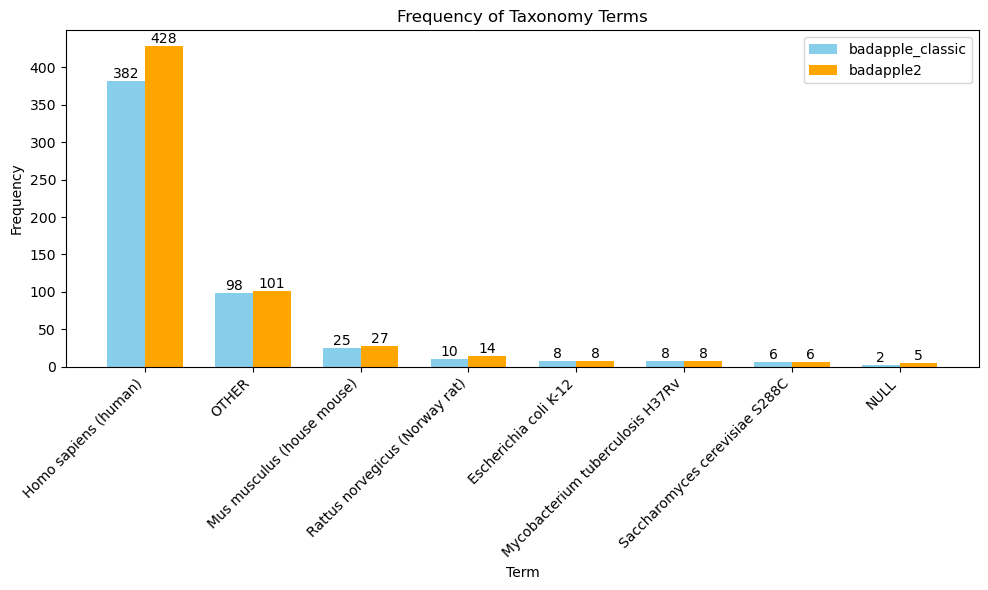

In [225]:
plot_frequency_comparison(df1, df2, ORIGINAL_DB_NAME, COMPARISON_DB_NAME, 
                          title_key, label_bars=True,
                          xtick_labels=xtick_labels)

# Close DB Connections

In [226]:
# Close the cursors
original_db_cur.close()
comparison_db_cur.close()

# Close the connections
original_db_connection.close()
comparison_db_connection.close()